# Analysing NYC High School Data

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"schools/{f}")
    data[key_name] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined = combined.copy()
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

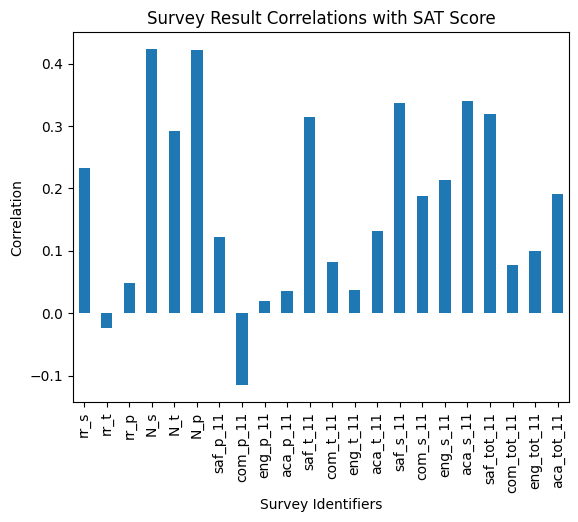

In [12]:
# Bar plot of the survey of parents, teachers and students data correlations with sat_score
correlations[survey_fields].plot.bar(title='Survey Result Correlations with SAT Score',
                                     xlabel='Survey Identifiers',
                                     ylabel='Correlation')
plt.show()

There are higher correlations between `sat_score` and columns `N_s`, `N-t` and `N_p`. These columns are all related to `total_enrollment` and would therefore be more likely to be higher.

There is some correlation with `rr_s` which indicates the volume of students that engaged in the survey may have an impact on scores, that is, engagement is higher.

Students and teachers views of safety in the acedemic environment reflects positively on results.

Finally, students' views of academic standards is positively correlated with `sat_score`, unlike teachers' and parents' views.

## Exploring Safety and SAT Scores

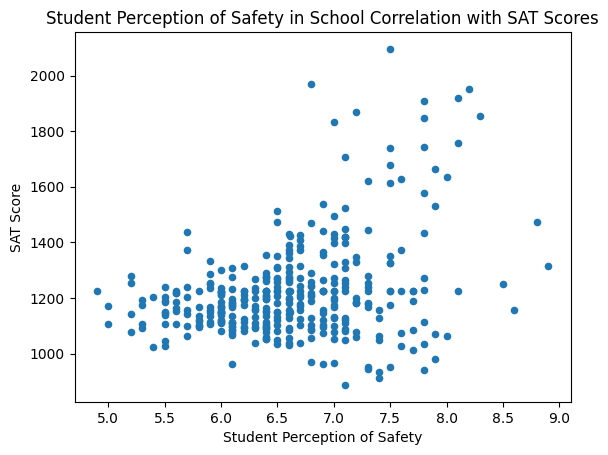

In [13]:
# Create a scatter plot of 'saf_s_11' and 'sat_score'
combined.plot.scatter(x='saf_s_11',
                      y='sat_score',
                      title='Student Perception of Safety in School Correlation with SAT Scores',
                      xlabel='Student Perception of Safety',
                      ylabel='SAT Score')
plt.show()

Whilst there appears to be a positive correlation with student perception of safety and SAT Scores, it isn't particularly strong. The higher SAT Scores all appear within the range of safety perception scores between just under 7.0 and 8.5. The extremely high perception scores don't seem to indicate better results.

In [14]:
# Average Safety Scores by Borough
safety_scores = combined[['boro', 'saf_s_11', 'saf_t_11', 'saf_p_11']].groupby('boro').agg('mean').reset_index()
safety_scores

,boro,saf_s_11,saf_t_11,saf_p_11
0,Bronx,6.606577,7.026882,8.346237
1,Brooklyn,6.370755,6.985849,8.036792
2,Manhattan,6.831370,7.287778,8.288889
3,Queens,6.721875,7.365625,8.098437
4,Staten Island,6.530000,7.210000,7.800000


Manhatten has the highest average safety perception score among students with Brooklyn the lowest.

## Exploring Race and SAT Scores

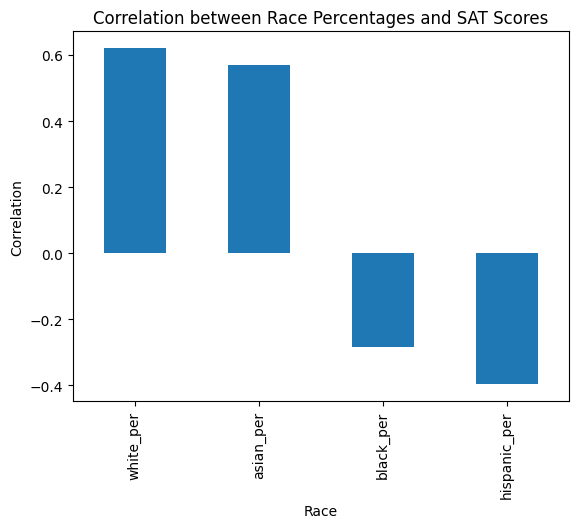

In [15]:
# Correlations between different race percentages
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[race_cols].plot.bar(title='Correlation between Race Percentages and SAT Scores',
                                 xlabel='Race',
                                 ylabel='Correlation')
plt.show()

Higher White and Asian percentages seem to correlate positively with SAT Scores whilst Black and especially Hispanic percentages impact negatively.

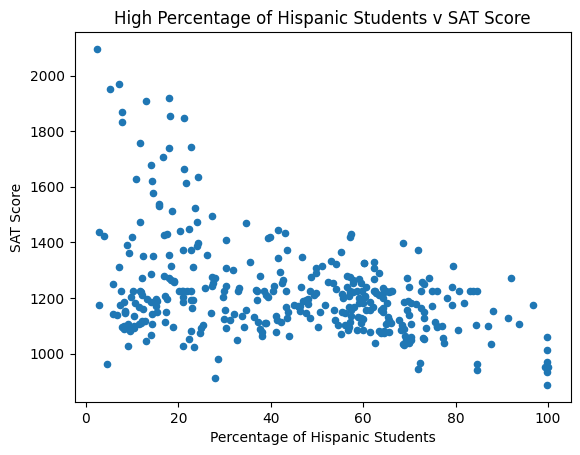

In [16]:
# Explore 'hispanic_per' further
combined.plot.scatter(x='hispanic_per',
                          y='sat_score',
                          title='High Percentage of Hispanic Students v SAT Score',
                          xlabel='Percentage of Hispanic Students',
                          ylabel='SAT Score')
plt.show()

There is a strong negative correlation between the percentage of Hispanic students and SAT Scores.

In [17]:
hisp_schools = combined[combined['hispanic_per'] > 95]['SCHOOL NAME']
hisp_schools

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools with a higher percentage of Hispanic students would seem to accommodate English learners predominately and is a possible explanation of the lower SAT scores.

In [18]:
not_hisp_schools = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']
not_hisp_schools

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools with a low percentage of Hispanic students and higher SAT scores appear to be specialised science and technology schools that receive extra funding and only admit students who pass an entrance exam.

While this doesn't explain the low percentage of Hispanic students, it does explain why these students achieve higher SAT scores.

## Exploring Gender and SAT Scores

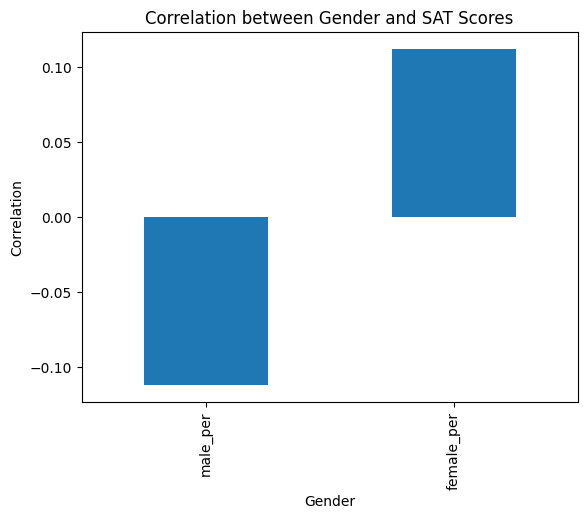

In [19]:
# Gender differences in SAT Scores
correlations[['male_per', 'female_per']].plot.bar(title='Correlation between Gender and SAT Scores',
                                                  xlabel='Gender',
                                                  ylabel='Correlation')
plt.show()

There is weak correlation between gender and SAT scores with schools with a high percentage of female students having a positive correlation and the opposite for male.

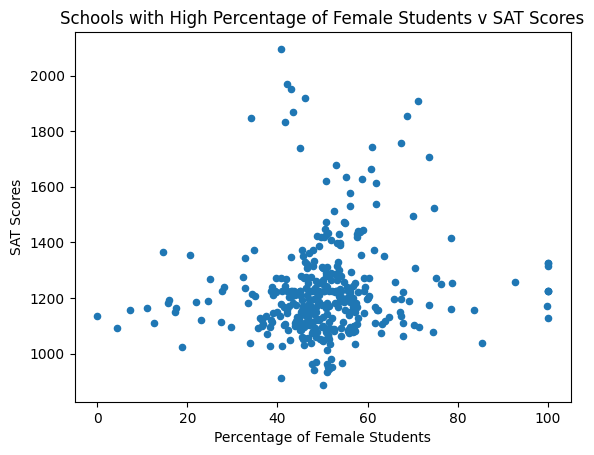

In [20]:
# Investigate high female_per further
combined.plot.scatter(x='female_per',
                      y='sat_score',
                      title='Schools with High Percentage of Female Students v SAT Scores',
                      xlabel='Percentage of Female Students',
                      ylabel='SAT Scores')
plt.show()

There is no strong correlation between the percentage of female students and SAT scores. Schools that are all girl don't achieve unusually high scores.

In [21]:
female_high_scores = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_high_scores['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools look to be selective liberal arts schools that have high academic standards.

## Exploring AP Scores vs SAT Scores

In [22]:
# Percentage of students in each school that took an AP exam...
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

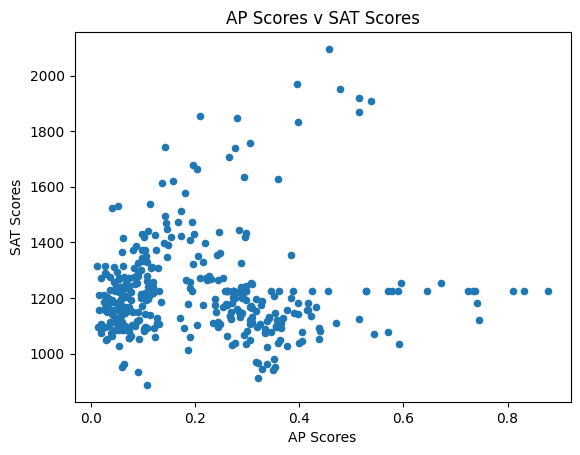

In [23]:
# Relationship between AP scores and SAT scores...
combined.plot.scatter(x='ap_per',
                      y='sat_score',
                      title='AP Scores v SAT Scores',
                      xlabel='AP Scores',
                      ylabel='SAT Scores')
plt.show()

There could be a relationship between AP scores and SAT scores but it's not strong or obvious.